<a href="https://colab.research.google.com/github/ldivrala/Face-Recognition-Training/blob/main/TFace_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import numpy as np
from tensorflow import keras
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import time
import os
import copy
import PIL


Load dataset from google drive

In [ ]:
# Connect with Google Drive for dataset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Zips/trainset.zip -d /content/sample_data

Archive:  /content/drive/MyDrive/Zips/trainset.zip
replace /content/sample_data/trainset/0001/0001_0000255/0000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Dataset creation Process

In [ ]:
import random
dataset = []
trainset_dirs = "/content/sample_data/trainset/"

for trainset_dir in os.listdir(trainset_dirs):
    image_dirs = os.listdir(trainset_dirs+ trainset_dir)
    
    for i in range(len(image_dirs)):
        image_dir = image_dirs[i]
        images = os.listdir(trainset_dirs+ trainset_dir + "/" + image_dir)
        images_dir = trainset_dirs+ trainset_dir + "/" + image_dir
        
        for image1 in images:
            for image2 in images:
                if image1 != image2:
                    img_path1 = images_dir + "/" + image1
                    img_path2 = images_dir + "/" + image2
                    
                    dataset.append([img_path1, img_path2, 1])
                
        i2 = random.randint(0, len(image_dirs)-1)
        i3 = random.randint(0, len(image_dirs)-1)
        i4 = random.randint(0, len(image_dirs)-1)
        

        random_image_dirs = [image_dirs[i2], image_dirs[i3],image_dirs[i4]]
    
        for image_dir2 in random_image_dirs:
            images_dir2 = trainset_dirs + trainset_dir + "/" + image_dir2
            
            if image_dir2 != image_dir:
                images2 = os.listdir(trainset_dirs+ trainset_dir + "/" + image_dir2)

                for image1 in images2:
                    for image2 in images:
                        img_path1 = images_dir2 + "/" + image1
                        img_path2 = images_dir + "/" + image2
                        
                        dataset.append([img_path1, img_path2, 0])



### Create dataset pipeline with generator
We will use inceptionV3 pretrained model for features extraction

In [ ]:
from keras.applications.inception_v3 import preprocess_input

dataset = np.array(dataset)
np.random.shuffle(dataset)

image1_filenames = dataset[:, 0]
image2_filenames = dataset[:, 1]
image_labels = tf.constant(dataset[:, 2], name="labels", dtype = tf.float32)

def dataset_generator():
  for i in range(len(dataset)):
    
    image1 = tf.constant(np.asarray(PIL.Image.open(image1_filenames[i]).convert('RGB')), dtype = tf.float32)
    image2 = tf.constant(np.asarray(PIL.Image.open(image2_filenames[i]).convert('RGB')), dtype = tf.float32)
    input_image1 = tf.image.resize(image1, (299, 299), method = "nearest")
    input_image2 = tf.image.resize(image2, (299, 299), method = "nearest") 
    
    input_image1 = preprocess_input(input_image1)
    input_image2 = preprocess_input(input_image2)

    yield ({
        "image_1": input_image1,
        "image_2": input_image2
    }, image_labels[i])


tf_dataset = tf.data.Dataset.from_generator(dataset_generator, 
                                            output_signature = ({
                                                "image_1": tf.TensorSpec((299, 299, 3), dtype = tf.float32),
                                                "image_2": tf.TensorSpec((299, 299, 3), dtype = tf.float32)
                                            }, 
                                            tf.TensorSpec((), dtype = tf.float32)
                                            ))

for img, label in tf_dataset.take(3):
    print(img["image_1"].shape, img["image_2"].shape, label)

(299, 299, 3) (299, 299, 3) tf.Tensor(0.0, shape=(), dtype=float32)
(299, 299, 3) (299, 299, 3) tf.Tensor(0.0, shape=(), dtype=float32)
(299, 299, 3) (299, 299, 3) tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image 1", "Input Image 2"]
    
    for i in range(len(display_list) - 1):
        plt.subplot(1, len(display_list) - 1, i+1)

        plt.title(title[i] + " Label: " + str(display_list[2].numpy()))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    
    plt.show()



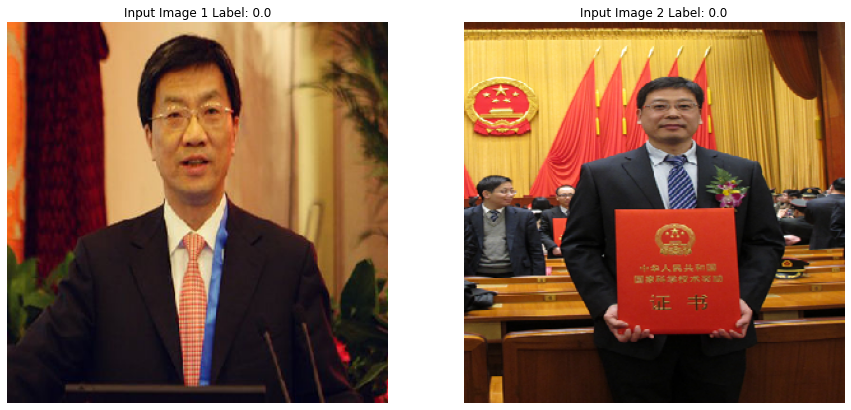

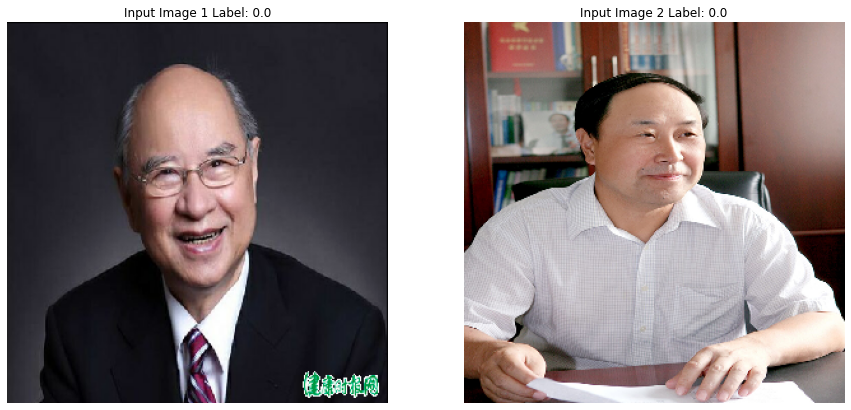

In [ ]:
for images, label in tf_dataset.take(2):
    display([images["image_1"], images["image_2"], label])


Download inception Network

In [ ]:
inception3 = tf.keras.applications.InceptionV3(
            include_top=False,
            weights="imagenet",
            classifier_activation=None,
        )

inception3.trainable = False

Model creation

In [ ]:
i1 = keras.Input(shape=(299, 299, 3), name = "image_1")
i2 = keras.Input(shape=(299, 299, 3), name = "image_2")

x1 = inception3(i1)
x2 = inception3(i2)

x1 = keras.layers.MaxPool2D(2)(x1)
x2 = keras.layers.MaxPool2D(2)(x2)

x1 = keras.layers.Conv2D(512, 1, padding = "same", activation="relu")(x1)
x2 = keras.layers.Conv2D(512, 1, padding = "same",  activation="relu")(x2)

x1 = keras.layers.Dropout(0.3)(x1)
x2 = keras.layers.Dropout(0.3)(x2)

x1 = keras.layers.MaxPool2D(4)(x1)
x2 = keras.layers.MaxPool2D(4)(x2)

x1 = keras.layers.Conv2D(256, 1, padding = "same",  activation="relu")(x1)
x2 = keras.layers.Conv2D(256, 1, padding = "same",  activation="relu")(x2)

x1 = keras.layers.GlobalMaxPool2D()(x1)
x2 = keras.layers.GlobalMaxPool2D()(x2)

x = keras.layers.Concatenate(axis = 1)([x1, x2])

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)

output = keras.layers.Dense(1)(x)

model = keras.models.Model([i1, i2], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, None, None, 2 21802784    image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 4, 4, 2048)   0           inception_v3[0][0]           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001) ,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=["accuracy"])

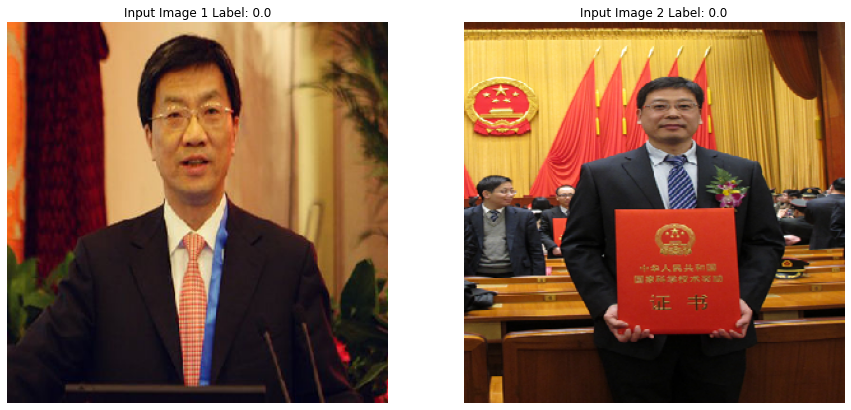

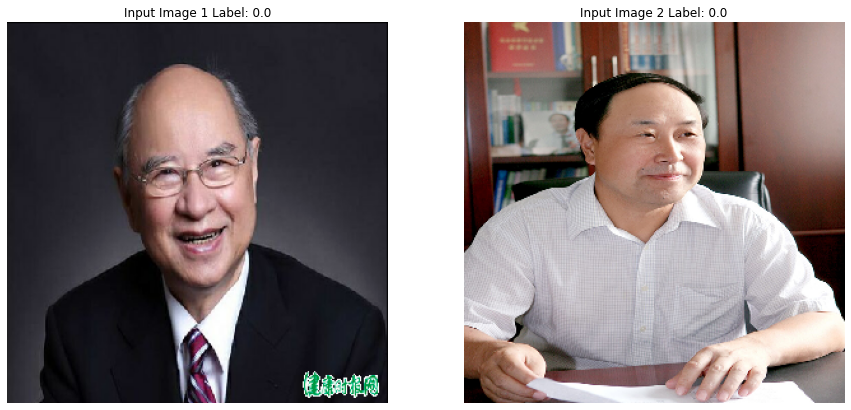

In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BATCH_SIZE = 4

# preprocess_image_ds=  preprocess_image_ds.batch(BATCH_SIZE)
train_dataset = tf_dataset.batch(BATCH_SIZE)

for images, label in train_dataset.take(1):
  for i in range(2):
    display([images["image_1"][i], images["image_2"][i], label[i]])

### Train our model
We have to train our model for more than 500 epochs to get a better result
Here we have trained for 5 epochs only

In [ ]:
model_history = model.fit(train_dataset, epochs=EPOCHS)

Epoch 1/5
    204/Unknown - 54s 136ms/step - loss: 0.8123 - accuracy: 0.6850

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


19309/19309 [==============================] - 2500s 128ms/step - loss: 0.5781 - accuracy: 0.7429
Epoch 2/5
19309/19309 [==============================] - 2410s 125ms/step - loss: 0.5663 - accuracy: 0.7443
Epoch 3/5
19309/19309 [==============================] - 2414s 125ms/step - loss: 0.5609 - accuracy: 0.7443
Epoch 4/5
19309/19309 [==============================] - 2435s 126ms/step - loss: 0.5545 - accuracy: 0.7444
Epoch 5/5
19309/19309 [==============================] - 2432s 126ms/step - loss: 0.5473 - accuracy: 0.7452


In [ ]:
model.save("/content/drive/MyDrive/Models/FaceRecognition/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/FaceRecognition/assets


Evalution of our model

In [ ]:
labels = []
for i in train_dataset.take(100):
  for label in i[1]:
    labels.append(label)

y_pred = (tf.math.sigmoid(model.predict(train_dataset.take(100))) > 0.5).numpy()

y_pred.shape, len(labels)

((400, 1), 400)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(confusion_matrix(labels, y_pred))

[[303   2]
 [ 89   6]]


In [ ]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87       305
         1.0       0.75      0.06      0.12        95

    accuracy                           0.77       400
   macro avg       0.76      0.53      0.49       400
weighted avg       0.77      0.77      0.69       400

